In [1]:
import gymnasium as gym
import os
import numpy as np
import matplotlib.pyplot as plt
import wandb
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv


from stable_baselines3.common.callbacks import CallbackList, CheckpointCallback, EvalCallback
import cv2
import ale_py
from wandb.integration.sb3 import WandbCallback
from stable_baselines3.common.monitor import Monitor
from PIL import Image
import supersuit as ss
from stable_baselines3.common.vec_env import VecTransposeImage


C:\Users\propietari\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# pip install pettingzoo supersuit

In [2]:
import ppo_pong_constants as constants

In [3]:
env = gym.make("PongNoFrameskip-v4", render_mode="rgb_array")

print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))

Action space is Discrete(6) 
Observation space is Box(0, 255, (210, 160, 3), uint8) 


In [4]:
def watch_untrained_agent(env):
    gif_folder = "pong_videos_untrained_agent"
    os.makedirs(gif_folder, exist_ok=True)

    episode_rewards = []
    for episode in range(100):
        state, _ = env.reset()
        rewards = []
        images = []

        for t in range(10000):
            # Randomly select an action (untrained agent)
            action = env.action_space.sample()

            # Render the environment and save the frame
            img = env.render()
            images.append(Image.fromarray(img))

            # Execute action and get reward and new state
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            rewards.append(reward)

            if done:
                # Add the total reward of this episode to the list
                episode_rewards.append(sum(rewards))

                # Save a GIF if the episode is a multiple of 10
                if (episode + 1) % 10 == 0:
                    gif_filename = os.path.join(gif_folder, f"untrained_agent_episode_{episode + 1}.gif")
                    images[0].save(
                        gif_filename,
                        save_all=True,
                        append_images=images[1:],
                        duration=60,
                        loop=0,
                    )
                    print(f"Saved GIF for Episode {episode + 1} as {gif_filename}")
                break

    return episode_rewards

Saved GIF for Episode 10 as pong_videos_untrained_agent\untrained_agent_episode_10.gif
Saved GIF for Episode 20 as pong_videos_untrained_agent\untrained_agent_episode_20.gif
Saved GIF for Episode 30 as pong_videos_untrained_agent\untrained_agent_episode_30.gif
Saved GIF for Episode 40 as pong_videos_untrained_agent\untrained_agent_episode_40.gif
Saved GIF for Episode 50 as pong_videos_untrained_agent\untrained_agent_episode_50.gif
Saved GIF for Episode 60 as pong_videos_untrained_agent\untrained_agent_episode_60.gif
Saved GIF for Episode 70 as pong_videos_untrained_agent\untrained_agent_episode_70.gif
Saved GIF for Episode 80 as pong_videos_untrained_agent\untrained_agent_episode_80.gif
Saved GIF for Episode 90 as pong_videos_untrained_agent\untrained_agent_episode_90.gif
Saved GIF for Episode 100 as pong_videos_untrained_agent\untrained_agent_episode_100.gif
[-21.0, -21.0, -21.0, -19.0, -20.0, -20.0, -20.0, -19.0, -20.0, -21.0, -18.0, -20.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -

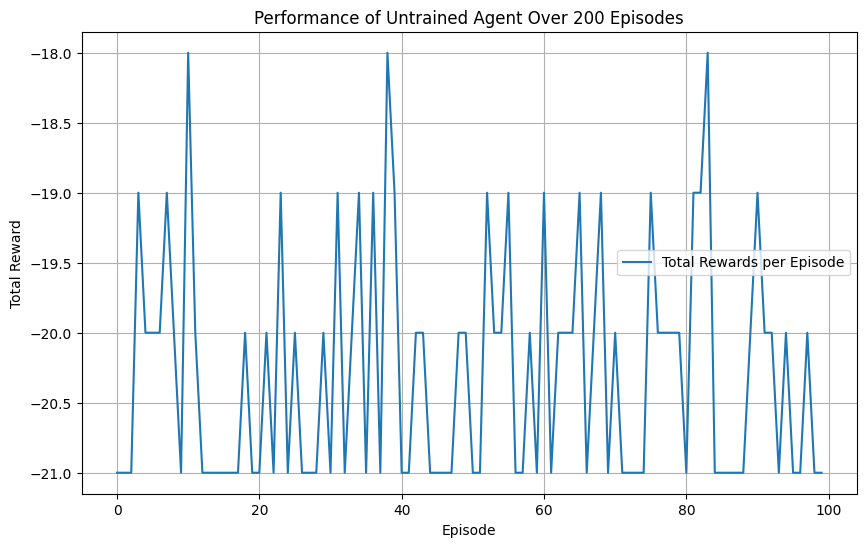

In [5]:
episode_rewards = watch_untrained_agent(env)

print(episode_rewards)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label="Total Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Performance of Untrained Agent Over 100 Episodes")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
run = wandb.init(
    project="PPO Pong",
    config={
        "env_id": constants.env_id,
        'Policy':constants.policy,
        "algorithm": constants.algorithm,
        "learning_rate": constants.learning_rate,  
        "gamma": constants.gamma,
        "gae_lambda": constants.gae_lambda,
        "n_steps": constants.n_steps,  
        "ent_coef": constants.ent_coef, 
        "vf_coef": constants.vf_coef,
        "clip_range": constants.clip_range, 
        "clip_range_vf": constants.clip_range_vf,
        "n_epochs": constants.n_epochs, 
        "batch_size": constants.batch_size, 
        "max_grad_norm": constants.max_grad_norm,
        "total_timesteps": constants.total_timesteps,
        "model_name": constants.model_name,
        "export_path": constants.export_path,
        "videos_path": constants.videos_path,
    },
    sync_tensorboard=True,
    save_code=True,
)


env = gym.make("PongNoFrameskip-v4")
env = gym.wrappers.AtariPreprocessing(
    env, 
    frame_skip=4, 
    grayscale_obs=False,  
    scale_obs=False  
    )
env = Monitor(env, allow_early_resets=True) 
env = ss.color_reduction_v0(env, mode='B')  # Reduces the color of frames to black and white
env = ss.resize_v1(env, x_size=84, y_size=84)  # Resize the observation space
env = ss.frame_stack_v1(env, 4)  # Stack 4 frames together
env = ss.dtype_v0(env, dtype='uint8')
env = DummyVecEnv([lambda: env])
env = VecTransposeImage(env)  # Convert channel-last to channel-first (C, H, W)


print("Observation space type:", type(env.observation_space))
print("Observation space details:", env.observation_space)

obs = env.reset()
print("Sample observation shape:", obs.shape)

# Define the PPO model
model = PPO(
    "CnnPolicy",  
    env,
    learning_rate = constants.learning_rate,
    gamma = constants.gamma,
    gae_lambda = constants.gae_lambda,
    n_steps = constants.n_steps,
    ent_coef = constants.ent_coef,
    vf_coef = constants.vf_coef,
    clip_range_vf = constants.clip_range_vf,
    clip_range = constants.clip_range,
    n_epochs = constants.n_epochs,
    batch_size = constants.batch_size,
    max_grad_norm = constants.max_grad_norm,
    verbose = 2,
    tensorboard_log = f"runs/{run.id}",
)

eval_env = gym.make("PongNoFrameskip-v4")
eval_env = gym.wrappers.AtariPreprocessing(
    eval_env, 
    frame_skip=4, 
    grayscale_obs=False,  
    scale_obs=False  
    )
eval_env = Monitor(eval_env, allow_early_resets=True)
eval_env = ss.color_reduction_v0(eval_env, mode='B')  # Grayscale
eval_env = ss.resize_v1(eval_env, x_size=84, y_size=84)  # Resize
eval_env = ss.frame_stack_v1(eval_env, 4)  # Stack 4 frames
eval_env = ss.dtype_v0(eval_env, dtype='uint8')  # Correct dtype
eval_env = DummyVecEnv([lambda: eval_env])  # VecEnv wrapping
eval_env = VecTransposeImage(eval_env)  # Channel-first format



eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=False, render=False)

checkpoint_callback = CheckpointCallback(
    save_freq=1000,  # Save the model every 1000 steps
    save_path='./checkpoints/',  # Directory to save the checkpoints
    name_prefix="ppo_pong",  # Prefix for the checkpoint filenames
)

callback_list = CallbackList([WandbCallback(verbose=2), eval_callback, checkpoint_callback])

# Train the model
print("Training...")
model.learn(total_timesteps=constants.total_timesteps, callback=callback_list)

# Save the trained model
model_path = os.path.join(constants.export_path, constants.model_name)
model.save(model_path)
wandb.save(model_path + ".zip")
wandb.finish()

# Close the training environment
env.close()



Observation space type: <class 'gymnasium.spaces.box.Box'>
Observation space details: Box(0, 255, (4, 84, 84), uint8)
Sample observation shape: (1, 4, 84, 84)
Using cpu device
Training...
Logging to runs/4tnw0qml\PPO_1
----------------------------
| time/              |     |
|    fps             | 287 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 128 |
----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 176        |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 256        |
| train/                  |            |
|    approx_kl            | 0.01782043 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    clip_range_vf        | 1          |
|    entropy_loss         | -1.79      |
|    explained_variance   | 0.00195    |
|    learning_rate        | 0.0005     |
|   

In [2]:
def test_model(model, env, n_episodes=100):
    gif_folder = "videos_trained_agent"
    os.makedirs(gif_folder, exist_ok=True)

    rewards_per_episode = []
    episode_lengths = []

    # Run test episodes
    for episode in range(n_episodes):
        obs = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False

        images = []

        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_reward += reward[0]  # reward is in list format
            episode_length += 1

            img = env.render()
            images.append(Image.fromarray(img))

        rewards_per_episode.append(episode_reward)
        episode_lengths.append(episode_length)
        print(f"Episode {episode + 1}: Reward = {episode_reward}, Length = {episode_length}")

        if done:
            if (episode + 1) % 10 == 0:
                gif_filename = os.path.join(gif_folder, f"ppo_trained_agent_episode_{episode + 1}.gif")
                images[0].save(
                    gif_filename,
                    save_all=True,
                    append_images=images[1:],
                    duration=60,
                    loop=0,
                )
                print(f"Saved GIF for Episode {episode + 1} as {gif_filename}")

    # Print statistics
    print(f"Testing completed: {n_episodes} episodes")
    print(f"Mean reward: {np.mean(rewards_per_episode):.2f}")
    print(f"Std of rewards: {np.std(rewards_per_episode):.2f}")
    print(f"Max reward: {np.max(rewards_per_episode)}")
    print(f"Min reward: {np.min(rewards_per_episode)}")

    # Return metrics for further analysis
    return rewards_per_episode, episode_lengths

Testing...
Episode 1: Reward = -10.0, Length = 3696
Episode 2: Reward = -7.0, Length = 3834
Episode 3: Reward = 9.0, Length = 3165
Episode 4: Reward = -8.0, Length = 3867
Episode 5: Reward = -18.0, Length = 3123
Episode 6: Reward = -15.0, Length = 3080
Episode 7: Reward = -6.0, Length = 4913
Episode 8: Reward = 3.0, Length = 4653
Episode 9: Reward = -1.0, Length = 4909
Episode 10: Reward = 3.0, Length = 4597
Saved GIF for Episode 10 as videos_trained_agent\ppo_trained_agent_episode_10.gif
Episode 11: Reward = -9.0, Length = 3980
Episode 12: Reward = 1.0, Length = 4715
Episode 13: Reward = -1.0, Length = 4442
Episode 14: Reward = -12.0, Length = 3458
Episode 15: Reward = -3.0, Length = 4589
Episode 16: Reward = -9.0, Length = 3980
Episode 17: Reward = -6.0, Length = 4465
Episode 18: Reward = -16.0, Length = 3166
Episode 19: Reward = -9.0, Length = 4167
Episode 20: Reward = 4.0, Length = 4063
Saved GIF for Episode 20 as videos_trained_agent\ppo_trained_agent_episode_20.gif
Episode 21: Re

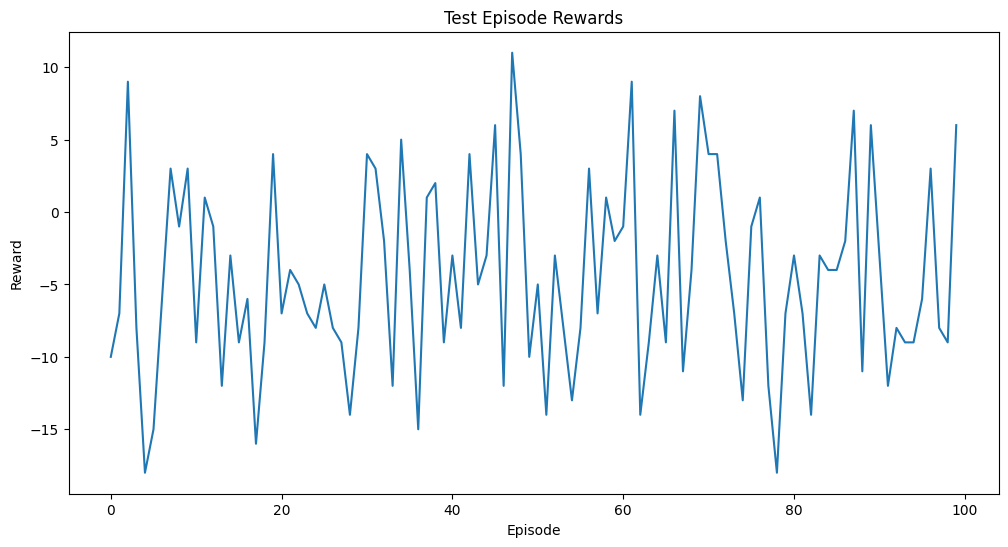

In [5]:

test_env = gym.make('ALE/Pong-v5', render_mode='rgb_array')
test_env = Monitor(test_env, allow_early_resets=True)
test_env = ss.color_reduction_v0(test_env, mode='B')  # Grayscale
test_env = ss.resize_v1(test_env, x_size=84, y_size=84)  # Resize
test_env = ss.frame_stack_v1(test_env, 4)  # Stack 4 frames
test_env = ss.dtype_v0(test_env, dtype='uint8')  # Correct dtype
test_env = DummyVecEnv([lambda: test_env])  # VecEnv wrapping
test_env = VecTransposeImage(test_env)  # Channel-first format

# Load the trained PPO model
model_path = r"logs\best_model.zip"

model = PPO.load(model_path)

# Test the model
print("Testing...")
rewards_per_episode, episode_lengths = test_model(model, test_env, n_episodes=100)

# Plot results: Reward per episode
plt.figure(figsize=(12, 6))
plt.plot(rewards_per_episode)
plt.title("Test Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

test_env.close()



In [ ]:

env = gym.make("PongNoFrameskip-v4", render_mode = 'rgb_array')
env = gym.wrappers.AtariPreprocessing(
    env, 
    frame_skip=4, 
    grayscale_obs=False,  
    scale_obs=False  
    )
env = Monitor(env, allow_early_resets=True) 
env = ss.color_reduction_v0(env, mode='B')  # Reduces the color of frames to black and white
env = ss.resize_v1(env, x_size=84, y_size=84)  # Resize the observation space
env = ss.frame_stack_v1(env, 4)  # Stack 4 frames together
env = ss.dtype_v0(env, dtype='uint8')
env = DummyVecEnv([lambda: env])
env = VecTransposeImage(env)  # Convert channel-last to channel-first (C, H, W)

test_env = env

# test_env = gym.make('ALE/Pong-v5', render_mode='rgb_array')
# test_env = Monitor(test_env, allow_early_resets=True)
# test_env = ss.color_reduction_v0(test_env, mode='B')  # Grayscale
# test_env = ss.resize_v1(test_env, x_size=84, y_size=84)  # Resize
# test_env = ss.frame_stack_v1(test_env, 4)  # Stack 4 frames
# test_env = ss.dtype_v0(test_env, dtype='uint8')  # Correct dtype
# test_env = DummyVecEnv([lambda: test_env])  # VecEnv wrapping
# test_env = VecTransposeImage(test_env)  # Channel-first format

# Load the trained PPO model
model_path = r"logs\cluster_pong_2.zip"

model = PPO.load(model_path)

# Test the model
print("Testing...")
rewards_per_episode, episode_lengths = test_model(model, test_env, n_episodes=10)

# Plot results: Reward per episode
plt.figure(figsize=(12, 6))
plt.plot(rewards_per_episode)
plt.title("Test Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

test_env.close()



Testing...
Episode 1: Reward = -21.0, Length = 3138


KeyboardInterrupt: 